In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from matplotlib.patches import Patch
import pickle
from sklearn.metrics import r2_score

from timeit import default_timer as timer

from IMU_JAE.vicon_methods import window_ml_data

# TF machine learning imports
from keras import Sequential, optimizers
from keras.layers import Dense
from keras.regularizers import l1 as L1, l2 as L2

%matplotlib notebook

Using TensorFlow backend.


In [2]:
def run_ml(data, target, subjs, model, plot='6', verbose=1, epochs=15, batch_size=128, validation_split=0, model_weights='nn_weights.h5'):
    pl.close('all')
    sc = []
    r2 = []
    figs = []
    model_hist = []
    for sub in np.unique(subjs):
        model.load_weights(model_weights)
        trn = subjs != sub  # TRaining Index
        tst = subjs == sub  # TEsting Index
        
        start = timer()
        hist = model.fit(data[trn], target[trn], verbose=verbose, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        train_time = timer() - start
        
        model_hist.append(hist)
        
        sc.append(model.evaluate(data[tst], target[tst], verbose=verbose)[1])

        pred = model.predict(data[tst])

        r2.append(r2_score(target[tst], pred))
        
        print(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
        
        if plot == '6':
            f, ax = pl.subplots(nrows=2, ncols=3, figsize=(12, 8))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
            for i in range(3):
                ax[0, i].plot(target[tst, i], label='Target')
                ax[0, i].plot(pred[:, i], '.', label='Prediction', alpha=0.25)
                ax[0, i].set_title('Sensor 1')
                ax[0, i].set_ylabel('Position [m]')
                ax[0, i].set_xlabel('Sample')
                ax[0, i].legend()
            for i in range(3):
                ax[1, i].plot(target[tst, i + 3], label='Target')
                ax[1, i].plot(pred[:, i + 3], '.', label='Prediction', alpha=0.25)
                ax[1, i].set_title('Sensor 2')
                ax[1, i].set_ylabel('Position [m]')
                ax[1, i].set_xlabel('Sample')
                ax[1, i].legend()
        elif plot == '2':
            f, ax = pl.subplots(2, figsize=(9, 5))
            f.suptitle(f'Subject: {sub}  Score: {sc[-1]:.4f}   Variance Score: {r2[-1]:.4f}  Time: {train_time:.2f}s')
            for i in range(2):
                ax[i].plot(target[tst, i], label='Target')
                ax[i].plot(pred[:, i], '.', label='Prediction', alpha=0.3)
                ax[i].set_title(f'Sensor {i+1}')
                ax[i].set_ylabel('Position [m]')
                ax[i].set_xlabel('Sample')
                ax[i].legend()
        elif plot is None:
            pass
        if plot is not None:
            f.tight_layout(rect=[0, 0.03, 1, 0.95])
            figs.append(f)
        
    return sc, r2, figs, model_hist

In [3]:
file = open('ml_raw.pickle', 'rb')
[a1, w1, wd1, a2, w2, wd2, c1, c2, cs1, cs2, subjs, locs, events] = pickle.load(file)
file.close()

In [4]:
dnw = np.concatenate((a1.values, a2.values, w1.values, w2.values, wd1.values, wd2.values), axis=1)
tnw = np.concatenate((cs1[:, 0].reshape((-1, 1)), cs2[:, 0].reshape((-1, 1))), axis=1)
# tnw = np.concatenate((c1.values, c2.values), axis=1)
# tnw = np.concatenate((cs1, cs2), axis=1)

In [5]:
dw, tw, subjs_w, _, _ = window_ml_data(dnw, tnw, 10, subjs, 'None', 'None')

In [8]:
model = Sequential()
# model.add(Dense(18, input_dim=dnw[0].size, activation='tanh'))
model.add(Dense(180, input_dim=dw[0].size, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(2))

optimizer = optimizers.Adam()

model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
model.save_weights('nn_weights.h5')

Subject: S0001  Score: 0.8739   Variance Score: 0.6528  Time: 33.29s
Subject: S0002  Score: 0.9163   Variance Score: 0.6201  Time: 34.74s
Subject: S0004  Score: 0.8325   Variance Score: 0.5586  Time: 33.95s
Subject: S0005  Score: 0.8755   Variance Score: 0.4831  Time: 33.25s
Subject: S0006  Score: 0.8734   Variance Score: 0.3982  Time: 34.39s
Subject: S0007  Score: 0.8979   Variance Score: 0.6056  Time: 33.98s
Subject: S0008  Score: 0.8863   Variance Score: -2.6466  Time: 36.77s


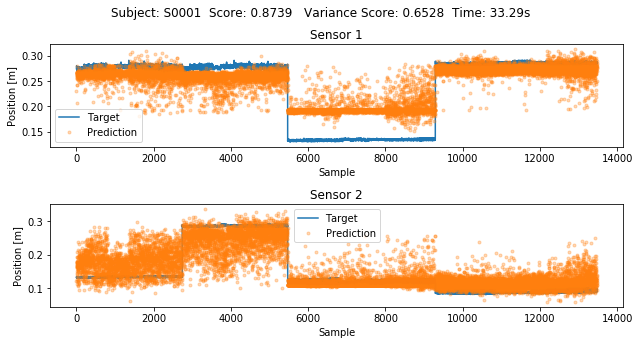

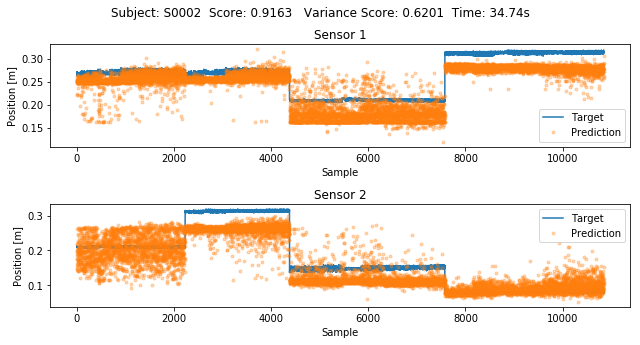

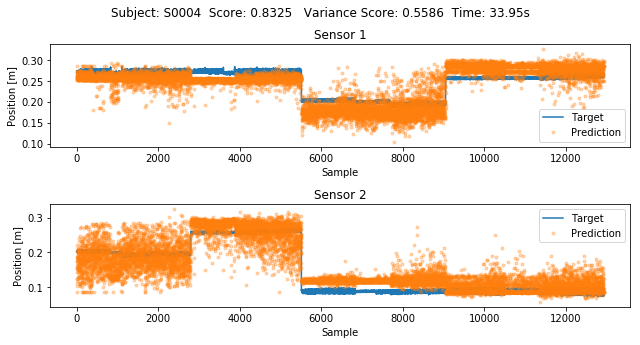

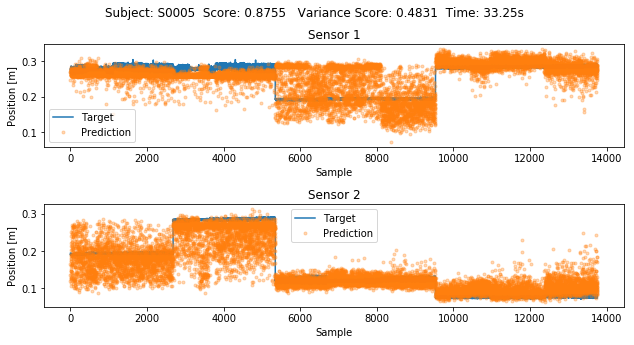

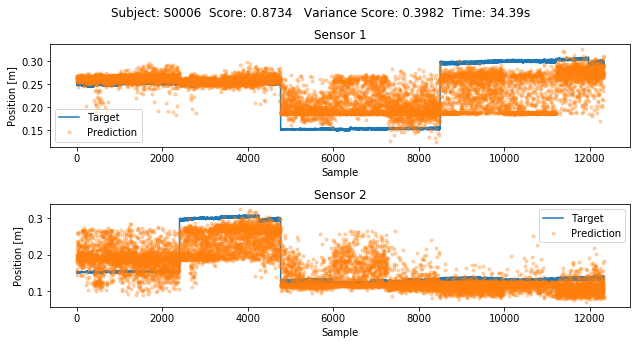

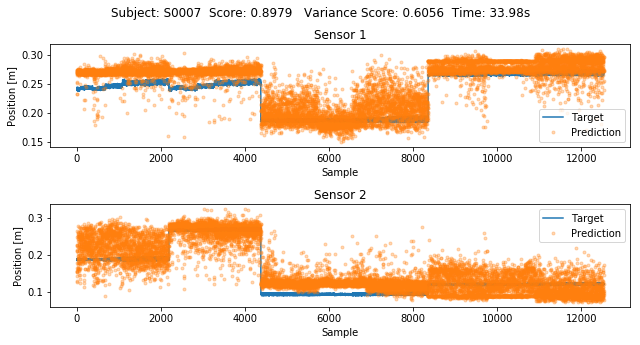

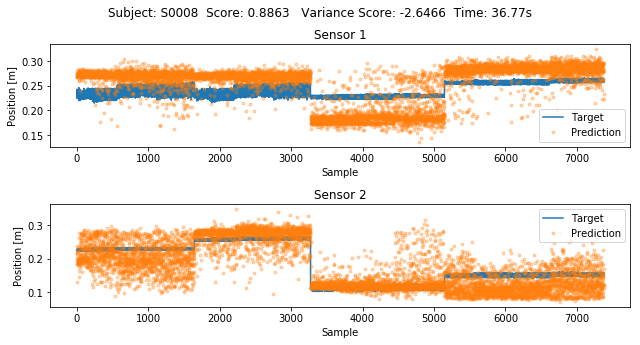

In [9]:
sc, r2, figs, mhist = run_ml(dw, tw, subjs_w, model, plot='2', verbose=0, epochs=20, batch_size=128, validation_split=0)

In [6]:
l_sc, l_r2 = pickle.load(open('nn_layers.pickle', 'rb'))

In [24]:
# l_sc = dict()
# l_r2 = dict()
name = '180r-8t-90t-2'
l_sc[name] = sc
l_r2[name] = r2

In [25]:
pickle.dump([l_sc, l_r2], open('nn_layers.pickle', 'wb'))

In [10]:
# 0-1, 1-2, 2-4, 3-5, 4-6, 5-7, 6-8
for i, s in enumerate([1,2,4,5,6,7,8]):
    figs[i].savefig(f'/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/Images/Neural Net Images/NN_jm_w10_180t-8r-90r-2_adam_e10_b128_S000{s}.png', bbox_to_inches='tight', transparent=True)

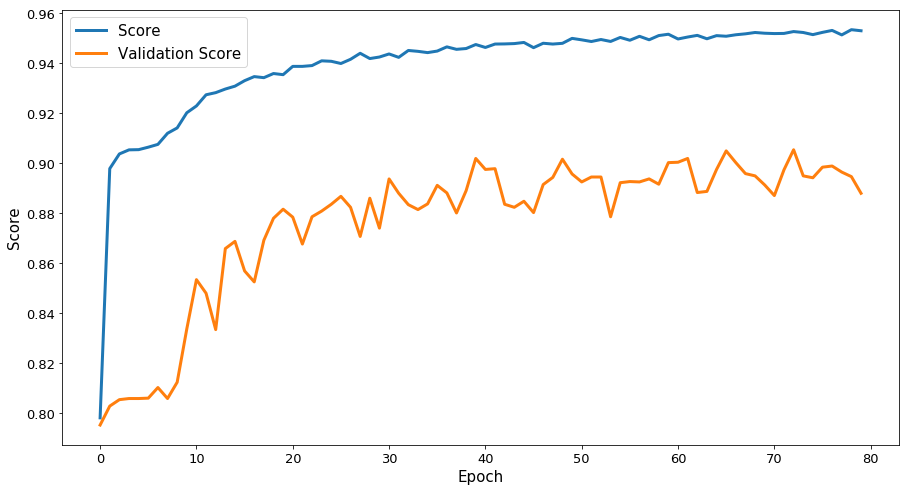

In [20]:
mhist[0].history.keys()
fh, axh = pl.subplots(figsize=(15, 8))
axh.plot(mhist[0].history['acc'], label='Score', linewidth=3)
axh.plot(mhist[0].history['val_acc'], label='Validation Score', linewidth=3)
axh.tick_params(axis='both', labelsize=13)
axh.set_xlabel('Epoch', fontsize=15)
axh.set_ylabel('Score', fontsize=15)
axh.legend(loc='best', fontsize=15)
# axh.set_ylim(0, 1)
fh.savefig('/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/Images/Neural Net Images/scores_zoom.png', bbox_to_inches='tight', transparent=True)

In [26]:
# Windowing scores
win_score = dict()
win_r2 = dict()
windows = [5, 10, 15, 20, 25, 30, 35, 40]

for win in windows:
    dw, tw, subjs_w, _, _ = window_ml_data(dnw, tnw, win, subjs, 'None', 'None')
    model = Sequential()
    model.add(Dense(18, input_dim=dw[0].size, activation='tanh'))
    model.add(Dense(15, activation='tanh'))
    model.add(Dense(6))
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    
    win_score[win], win_r2[win], figs = run_ml(dw, tw, subjs_w, model, plot=None, verbose=0, epochs=10, batch_size=128, validation_split=0)

Subject: S0001  Score: 0.5557   Variance Score: -3.5368  Time: 18.79s
Subject: S0002  Score: 0.4534   Variance Score: 0.0343  Time: 18.94s
Subject: S0004  Score: 0.3484   Variance Score: -1.5066  Time: 18.06s
Subject: S0005  Score: 0.0048   Variance Score: -1.3831  Time: 18.21s
Subject: S0006  Score: 0.5549   Variance Score: -2.3149  Time: 18.58s
Subject: S0007  Score: 0.5482   Variance Score: -0.1298  Time: 18.37s
Subject: S0008  Score: 0.1460   Variance Score: -0.9090  Time: 19.40s
Subject: S0001  Score: 0.5421   Variance Score: -3.5452  Time: 9.98s
Subject: S0002  Score: 0.3909   Variance Score: 0.0594  Time: 9.55s
Subject: S0004  Score: 0.3410   Variance Score: -1.3464  Time: 9.15s
Subject: S0005  Score: 0.0093   Variance Score: -1.3820  Time: 9.15s
Subject: S0006  Score: 0.5576   Variance Score: -2.4282  Time: 9.58s
Subject: S0007  Score: 0.5325   Variance Score: -0.1244  Time: 9.46s
Subject: S0008  Score: 0.1496   Variance Score: -1.1286  Time: 9.94s
Subject: S0001  Score: 0.6313

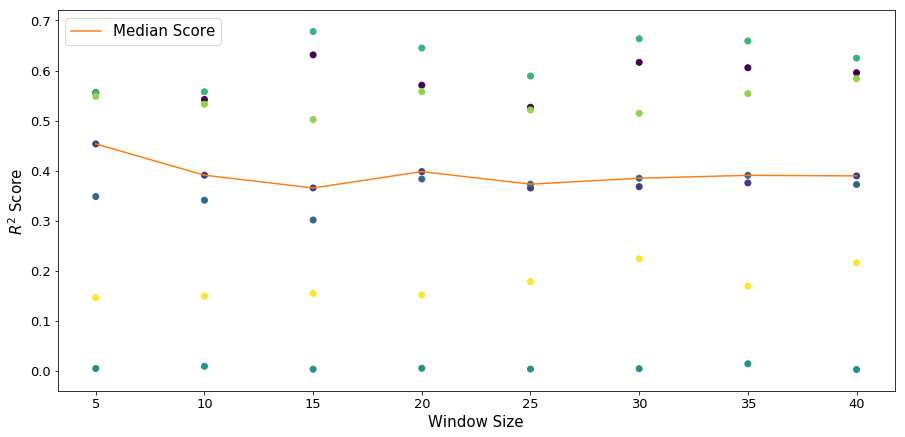

In [30]:
scores = np.array([win_score[key] for key in win_score.keys()])
rwins = np.repeat(windows, 7).reshape((8, 7))
c = np.tile(np.arange(7), 8).reshape((8, 7))

fwin, axwin = pl.subplots(figsize=(15, 7))
axwin.tick_params(axis='both', labelsize=13)
axwin.scatter(rwins, scores, c=c)
axwin.plot(windows, np.median(scores, axis=1), color='C1', label='Median Score')
axwin.legend(loc='best', fontsize=15)
axwin.set_xlabel('Window Size', fontsize=15)
axwin.set_ylabel(r'$R^2$ Score', fontsize=15)
fwin.savefig('/home/lukas/Dropbox/Masters/Class - Machine Learning/Project/Images/window_scores_nn.png', bbox_to_inches='tight', transparent=True)